In [1]:
import numpy as np
import pandas as pd
import json
import gc # For garbage collection, useful for managing memory with large datasets
import re # For regular expressions, used in column name cleaning
import os

# Scikit-learn for preprocessing and model evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score

# XGBoost and LightGBM for modeling
import xgboost as xgb
import lightgbm as lgb

# Matplotlib for plotting (for visualization of tuning results)
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
file_train_fraud_labels = 'C:/Big data analysis/finance-ba/datasets/train_fraud_labels.json'
with open(file_train_fraud_labels, 'r') as f:
    raw_json_data = json.load(f)
transaction_labels_dict = raw_json_data['target']
train_fraud_labels = pd.Series(transaction_labels_dict).reset_index()
train_fraud_labels.columns = ['transaction_id', 'is_fraud']
train_fraud_labels['transaction_id'] = pd.to_numeric(train_fraud_labels['transaction_id'])

transaction_df = pd.read_csv('C:/Big data analysis/finance-ba/datasets/transactions_data.csv')
card_df = pd.read_csv('C:/Big data analysis/finance-ba/datasets/cards_data.csv')
users_df = pd.read_csv('C:/Big data analysis/finance-ba/datasets/users_data.csv')
mcc_series = pd.read_json('C:/Big data analysis/finance-ba/datasets/mcc_codes.json', typ='series')
mcc_df = mcc_series.reset_index()
mcc_df.columns = ['mcc_code', 'description']

In [2]:
# --- Merge all DataFrames into one comprehensive DataFrame ---

# Start with the main transactions data
df = pd.merge(transaction_df, train_fraud_labels, left_on='id', right_on='transaction_id', how='left')

# Merge with card data (card_df.id is the card_id)
# Using suffixes to handle potential duplicate column names (e.g., 'id' in both)
df = pd.merge(df, card_df, left_on='card_id', right_on='id', how='left', suffixes=('', '_card'))

# Merge with user data (users_df.id is the client_id)
# Using suffixes again for robustness
df = pd.merge(df, users_df, left_on='client_id', right_on='id', how='left', suffixes=('', '_user'))

# Merge with MCC descriptions (mcc_df.mcc_code is the mcc)
# Note: 'mcc' is the code in transaction_df, 'mcc_code' is the code in mcc_df
df = pd.merge(df, mcc_df, left_on='mcc', right_on='mcc_code', how='left')

# --- Clean up merged columns ---
# Drop redundant ID columns from the merges
# 'transaction_id' is redundant with 'id' (from transaction_df)
# 'id_card' is redundant with 'card_id'
# 'id_user' is redundant with 'client_id'
# 'mcc_code' is redundant with 'mcc'
df = df.drop(columns=['transaction_id', 'id_card', 'id_user', 'mcc_code'])

# Delete original dataframes to free up memory
del transaction_df, train_fraud_labels, card_df, users_df, mcc_df
gc.collect() # Manually trigger garbage collection

print("All data merged into a single DataFrame and original tables deleted.")
print(f"Shape of the final merged DataFrame: {df.shape}")

All data merged into a single DataFrame and original tables deleted.
Shape of the final merged DataFrame: (13305915, 39)


In [3]:
# Drop rows where the fraud label is missing (these are unlabeled transactions)
# This is a critical step as supervised learning requires labeled data.
df.dropna(subset=['is_fraud'], inplace=True)

# Convert the target variable 'is_fraud' to a numerical format (0 for 'No', 1 for 'Yes')
# This is required by most machine learning algorithms.
df['is_fraud'] = df['is_fraud'].map({'No': 0, 'Yes': 1})

# Define features (X) and target (y)
features = [col for col in df.columns if col != 'is_fraud']
X = df[features]
y = df['is_fraud']

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training (60%), and a temporary set (40%)
# The first split takes 40% for temp, leaving 60% for X_train.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Split the temporary set (which is 40% of original) into validation (20% of original) and test (20% of original)
# 0.50 of X_temp (40%) = 20% of original.
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Delete the large intermediate dataframes to save memory (important for Kaggle kernels)
del df, X, y, X_temp, y_temp
gc.collect() # Manually trigger garbage collection

print("Full dataset split into training, validation, and test sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"X_test shape: {X_test.shape}")

Full dataset split into training, validation, and test sets.
X_train shape: (5348977, 38)
X_cv shape: (1782993, 38)
X_test shape: (1782993, 38)


In [5]:
import numpy as np
import pandas as pd

def apply_preprocessing(df, is_training_set=False, median_imputations=None):
    """
    Takes a raw data split and applies all feature engineering steps.
    """
    df_processed = df.copy()

    # --- Step 1: Clean Numerical Columns ---
    amount_cols = ['amount', 'per_capita_income', 'yearly_income', 'credit_limit', 'total_debt']
    for col in amount_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')

    # --- Step 2: Date Engineering ---
    date_cols = ['date', 'expires', 'acct_open_date']
    for col in date_cols:
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce', format='mixed')
    
    if 'date' in df_processed.columns:
        df_processed['hour_of_day'] = df_processed['date'].dt.hour
        df_processed['day_of_week'] = df_processed['date'].dt.dayofweek
        df_processed['month'] = df_processed['date'].dt.month
    if 'expires' in df_processed.columns and 'date' in df_processed.columns:
        df_processed['days_to_expiry'] = (df_processed['expires'] - df_processed['date']).dt.days
    
    # Drop original date columns right after use, as you suggested
    df_processed.drop(columns=[c for c in date_cols if c in df_processed.columns], inplace=True, errors='ignore')

    # --- Step 3: Cyclical Feature Creation ---
    cyclical_cols_original = ['hour_of_day', 'day_of_week', 'month']
    if all(col in df_processed.columns for col in cyclical_cols_original):
        df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour_of_day'] / 24.0)
        df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour_of_day'] / 24.0)
        df_processed['day_of_week_sin'] = np.sin(2 * np.pi * df_processed['day_of_week'] / 7.0)
        df_processed['day_of_week_cos'] = np.cos(2 * np.pi * df_processed['day_of_week'] / 7.0)
        df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12.0)
        df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12.0)
        
        # Drop original cyclical columns right after use, as you suggested
        df_processed.drop(columns=cyclical_cols_original, inplace=True)

    # --- Step 4: Process Binary and Other Features ---
    if 'errors' in df_processed.columns:
        df_processed['has_error'] = df_processed['errors'].notna().astype(int)
    if 'gender' in df_processed.columns:
        df_processed['gender'] = df_processed['gender'].map({'Female': 0, 'Male': 1})
    if 'has_chip' in df_processed.columns:
        df_processed['has_chip'] = df_processed['has_chip'].map({'NO': 0, 'YES': 1})
        
    # --- Step 5: Final NaN Imputation for numerical features (within this function) ---
    # This is done after all numerical features are created.
    # Medians will be calculated from X_train when this function is called on X_train.
    # Then passed to X_cv and X_test calls.
    numerical_cols_for_imputation = df_processed.select_dtypes(include=np.number).columns.tolist()
    if is_training_set:
        median_imputations = df_processed[numerical_cols_for_imputation].median()
    
    if median_imputations is not None:
        df_processed.fillna(median_imputations, inplace=True)

    return df_processed, median_imputations # Return processed DF and medians

print("Feature engineering function 'create_all_features' defined.")

Feature engineering function 'create_all_features' defined.


In [6]:
# --- Main preprocessing execution block ---
print("Step 1: Applying feature engineering to all data splits...")

# Initialize median_imputations_dict outside the loop; it will be populated by X_train's processing
median_imputations_dict = None

# Apply preprocessing to X_train (where medians for imputation are learned)
X_train, median_imputations_dict = apply_preprocessing(X_train, is_training_set=True)
# Apply preprocessing to X_cv and X_test (using medians learned from X_train)
X_cv, _ = apply_preprocessing(X_cv, median_imputations=median_imputations_dict)
X_test, _ = apply_preprocessing(X_test, median_imputations=median_imputations_dict)
gc.collect() # Clean up memory

print('Stage 1: Feature Engineering applied to all splits.')
print(f"X_train shape after initial FE: {X_train.shape}")
print(f"X_train columns after initial FE (first 10): {X_train.columns.tolist()[:10]}...")

Step 1: Applying feature engineering to all data splits...
Stage 1: Feature Engineering applied to all splits.
X_train shape after initial FE: (5348977, 43)
X_train columns after initial FE (first 10): ['id', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc']...


In [7]:
print("Step 2: Dropping all unnecessary columns...")

# This is the complete master list of columns to drop, consolidated from our discussions.
final_cols_to_drop = [
    # Identifiers and Sensitive Data
    'id', 'client_id', 'card_id', 'merchant_id',
    'card_number', 'cvv','mcc'

    # Problematic Date Columns (and their direct derivatives if still present)
    'acct_open_date', 'year_pin_last_changed',
    # 'account_age_days', 'years_since_pin_change' should be gone if derived from above

    # Redundant/Low-Value Categoricals/Text
    'card_on_dark_web', # This was a single-value column, so its OHE version 'card_on_dark_web_No' would also be single-value.
    'has_chip', # Replaced by 'has_chip_binary'
    'address', # High cardinality text, not used for FE
    'merchant_city', # High cardinality categorical, often redundant with zip/state

    # Redundant Age Features
    'birth_year',
    'birth_month',

    # Geospatial (dropped as I decided against complex geospatial FE)
    'latitude',
    'longitude',

    # Original Date Columns (replaced by extracted features)
    # These should be dropped by apply_preprocessing, but included here for robustness if they somehow remain.
    'date', 'expires',
    # 'hour_of_day', 'day_of_week', 'month' should also be dropped by apply_preprocessing
]

for df_set in [X_train, X_cv, X_test]:
    # Filter list to only drop columns that actually exist in the DataFrame
    cols_that_exist = [col for col in final_cols_to_drop if col in df_set.columns]
    df_set.drop(columns=cols_that_exist, inplace=True, errors='ignore') # Use errors='ignore' for robustness

print('Stage 2: Unnecessary columns dropped.')
print(f"X_train shape after dropping: {X_train.shape}")
print(f"X_train columns after dropping (first 10): {X_train.columns.tolist()[:10]}...")

Step 2: Dropping all unnecessary columns...
Stage 2: Unnecessary columns dropped.
X_train shape after dropping: (5348977, 28)
X_train columns after dropping (first 10): ['amount', 'use_chip', 'merchant_state', 'zip', 'mcc', 'errors', 'client_id_card', 'card_brand', 'card_type', 'num_cards_issued']...


In [8]:
from sklearn.preprocessing import OneHotEncoder
print("Step 3: Grouping and one-hot encoding...")

# --- Handle merchant_state: Grouping ---
# Group merchant_state based on training set fraud counts (CRUCIAL for no data leakage)
# This part needs to be outside the loop and use y_train.
# Ensure 'merchant_state' is clean (NaNs filled) before this step.
temp_train_df = pd.DataFrame({'merchant_state': X_train['merchant_state'], 'is_fraud': y_train})
fraud_counts = temp_train_df[temp_train_df['is_fraud'] == 1]['merchant_state'].value_counts()
top_15_fraud_states = fraud_counts.nlargest(15).index.tolist()
del temp_train_df, fraud_counts # Clean up temporary data

# Apply grouping to all splits using the list derived from X_train
for df_set in [X_train, X_cv, X_test]:
    if 'merchant_state' in df_set.columns:
        # Use .loc for safe assignment
        df_set.loc[:, 'merchant_state'] = df_set['merchant_state'].apply(lambda x: x if x in top_15_fraud_states else 'OTHER_STATE')


# --- One-Hot Encode all remaining 'object' type columns ---
# This includes 'merchant_state', 'errors', 'card_brand', 'card_type', 'description', 'use_chip'
# and 'gender' if they are still object type.
categorical_cols_to_encode = X_train.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns to encode: {categorical_cols_to_encode}')

# Initialize OneHotEncoder (fit only on X_train to prevent data leakage)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8)
encoder.fit(X_train[categorical_cols_to_encode])

# Transform and concatenate for all splits
encoded_cols_train = pd.DataFrame(encoder.transform(X_train[categorical_cols_to_encode]), index=X_train.index, columns=encoder.get_feature_names_out(categorical_cols_to_encode))
encoded_cols_cv = pd.DataFrame(encoder.transform(X_cv[categorical_cols_to_encode]), index=X_cv.index, columns=encoder.get_feature_names_out(categorical_cols_to_encode))
encoded_cols_test = pd.DataFrame(encoder.transform(X_test[categorical_cols_to_encode]), index=X_test.index, columns=encoder.get_feature_names_out(categorical_cols_to_encode))

X_train = pd.concat([X_train.drop(columns=categorical_cols_to_encode), encoded_cols_train], axis=1)
X_cv = pd.concat([X_cv.drop(columns=categorical_cols_to_encode), encoded_cols_cv], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols_to_encode), encoded_cols_test], axis=1)

gc.collect() # Clean up memory

print('Stage 3: Grouping and one-hot encoding complete.')
print(f"X_train shape after OHE: {X_train.shape}")
print(f"X_train columns after OHE (first 10): {X_train.columns.tolist()[:10]}...")

Step 3: Grouping and one-hot encoding...
Categorical columns to encode: ['use_chip', 'merchant_state', 'errors', 'card_brand', 'card_type', 'description']
Stage 3: Grouping and one-hot encoding complete.
X_train shape after OHE: (5348977, 178)
X_train columns after OHE (first 10): ['amount', 'zip', 'mcc', 'client_id_card', 'num_cards_issued', 'credit_limit', 'current_age', 'retirement_age', 'gender', 'per_capita_income']...


In [9]:
print("Step 4: Downcasting data types for memory efficiency...")
for df_set in [X_train, X_cv, X_test]:
    for col in df_set.select_dtypes(include=['float64', 'int64']).columns:
        if 'float' in str(df_set[col].dtype):
            df_set.loc[:, col] = df_set[col].astype('float32')
        else:
            df_set.loc[:, col] = pd.to_numeric(df_set[col], downcast='integer')
gc.collect() # Clean up memory

print("\n--- Preprocessing Fully Complete ---")
print(f"X_train final shape: {X_train.shape}")
print(f"X_cv final shape: {X_cv.shape}")
print(f"X_test final shape: {X_test.shape}")

Step 4: Downcasting data types for memory efficiency...

--- Preprocessing Fully Complete ---
X_train final shape: (5348977, 178)
X_cv final shape: (1782993, 178)
X_test final shape: (1782993, 178)


In [10]:
print("\n--- Final NaN Check Across ALL Remaining Columns ---")
nan_counts_xtrain = X_train.isna().sum()
print(f"\nX_train NaNs:")
print(nan_counts_xtrain[nan_counts_xtrain > 0]) # Should be empty!

nan_counts_xcv = X_cv.isna().sum()
print(f"\nX_cv NaNs:")
print(nan_counts_xcv[nan_counts_xcv > 0])

nan_counts_test = X_test.isna().sum()
print(f"\nX_test NaNs:")
print(nan_counts_test[nan_counts_test > 0])

if nan_counts_xtrain[nan_counts_xtrain > 0].empty and \
   nan_counts_xcv[nan_counts_xcv > 0].empty and \
   nan_counts_test[nan_counts_test > 0].empty:
    print("\nAll DataFrames are clean (no NaNs found). Ready for modeling!")
else:
    print("\nWARNING: NaNs still present in DataFrames. Please review preprocessing steps.")


--- Final NaN Check Across ALL Remaining Columns ---

X_train NaNs:
Series([], dtype: int64)

X_cv NaNs:
Series([], dtype: int64)

X_test NaNs:
Series([], dtype: int64)

All DataFrames are clean (no NaNs found). Ready for modeling!


In [11]:
# Calculate scale_pos_weight from the training target variable
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"Count of Legitimate Transactions (0) in y_train: {neg_count}")
print(f"Count of Fraudulent Transactions (1) in y_train: {pos_count}")
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}\n")

Count of Legitimate Transactions (0) in y_train: 5340978
Count of Fraudulent Transactions (1) in y_train: 7999
Calculated scale_pos_weight: 667.71



In [12]:
import xgboost as xgb

# Initialize and Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Metric for evaluation during training
    use_label_encoder=False,      # Suppress a future deprecation warning
    scale_pos_weight=scale_pos_weight_value, # Crucial for imbalance
    random_state=42,              # For reproducibility
    n_estimators=500,             # Number of boosting rounds (trees)
    learning_rate=0.05,           # Step size shrinkage to prevent overfitting
    max_depth=5,                  # Maximum depth of a tree
    subsample=0.7,                # Subsample ratio of the training instance
    colsample_bytree=0.7,         # Subsample ratio of columns when constructing each tree
    gamma=0.1                     # Minimum loss reduction required to make a further partition
)

print("Training XGBoost model...")
xgb_model.fit(X_train, y_train)
print("Model training complete.\n")

# Evaluate on Validation Set
y_pred_cv = xgb_model.predict(X_cv)
y_proba_cv = xgb_model.predict_proba(X_cv)[:, 1] # Probabilities for the positive class

print("--- Evaluation on Validation Set (X_cv) ---")
print("\nConfusion Matrix:")
print(confusion_matrix(y_cv, y_pred_cv))
print("\nClassification Report:")
print(classification_report(y_cv, y_pred_cv))
roc_auc = roc_auc_score(y_cv, y_proba_cv)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Display Feature Importances
print("\nFeature Importances (Top 15):")
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
print(feature_importances.nlargest(15))

Training XGBoost model...


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:01:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Evaluation on Validation Set (X_cv) ---

Confusion Matrix:
[[1743755   36571]
 [    182    2485]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780326
           1       0.06      0.93      0.12      2667

    accuracy                           0.98   1782993
   macro avg       0.53      0.96      0.55   1782993
weighted avg       1.00      0.98      0.99   1782993


ROC AUC Score: 0.9928

Feature Importances (Top 15):
merchant_state_Italy                                               0.118943
use_chip_Online Transaction                                        0.109049
description_Tolls and Bridge Fees                                  0.101288
zip                                                                0.031385
description_Taxicabs and Limousines                                0.030613
merchant_state_OTHER_STATE                                         0.028655
merchant_st

In [13]:
# Get feature importances from the model I just trained
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Identify the least important features to drop for tuning.
# I'll drop the bottom 10 features for this example. This number can be adjusted.
low_importance_features = feature_importances.nsmallest(10).index.tolist()

print(f"Identified {len(low_importance_features)} features with the lowest importance to drop for tuning.")

# Create reduced DataFrames for the search.
# RandomizedSearchCV will run on these smaller datasets to save time and memory.
X_train_model2 = X_train.drop(columns=low_importance_features, errors='ignore')
X_cv_model2 = X_cv.drop(columns=low_importance_features, errors='ignore')
X_test_model2=X_test.drop(columns=low_importance_features, errors='ignore')

del X_train,X_cv,X_test 
gc.collect()

print(f"New shape of X_train for tuning: {X_train_model2.shape}")
print(f"New shape of X_cv for tuning: {X_cv_model2.shape}")
print(f"New shape of X_test for tuning: {X_test_model2.shape}")

Identified 10 features with the lowest importance to drop for tuning.
New shape of X_train for tuning: (5348977, 168)
New shape of X_cv for tuning: (1782993, 168)
New shape of X_test for tuning: (1782993, 168)


In [14]:
print("\n--- Creating Interaction Features for Model 2's Reduced Datasets ---")

# List of all dataframes to apply interactions to (these are the already reduced ones)
dfs_for_interactions_model2 = [X_train_model2, X_cv_model2, X_test_model2]

for df_set in dfs_for_interactions_model2:
    # --- Amount x Top Categorical/Binary Features ---
    # Check if base columns exist and are numeric before creating interactions.
    
    if all(col in df_set.columns for col in ['amount', 'merchant_state_Italy']):
        df_set['amount_x_state_italy'] = df_set['amount'] * df_set['merchant_state_Italy']
    if all(col in df_set.columns for col in ['amount', 'description_Tolls and Bridge Fees']):
        df_set['amount_x_tolls'] = df_set['amount'] * df_set['description_Tolls and Bridge Fees']
    if all(col in df_set.columns for col in ['amount', 'use_chip_Online Transaction']):
        df_set['amount_x_online_trans'] = df_set['amount'] * df_set['use_chip_Online Transaction']
    if all(col in df_set.columns for col in ['amount', 'use_chip_Swipe Transaction']):
        df_set['amount_x_swipe_trans'] = df_set['amount'] * df_set['use_chip_Swipe Transaction']
    if all(col in df_set.columns for col in ['amount', 'merchant_state_Haiti']):
        df_set['amount_x_state_haiti'] = df_set['amount'] * df_set['merchant_state_Haiti']
    if all(col in df_set.columns for col in ['amount', 'description_Taxicabs and Limousines']):
        df_set['amount_x_taxis_limos'] = df_set['amount'] * df_set['description_Taxicabs and Limousines']
    if all(col in df_set.columns for col in ['amount', 'use_chip_Chip Transaction']):
        df_set['amount_x_chip_trans'] = df_set['amount'] * df_set['use_chip_Chip Transaction']
    if all(col in df_set.columns for col in ['amount', 'merchant_state_OTHER_STATE']):
        df_set['amount_x_state_other'] = df_set['amount'] * df_set['merchant_state_OTHER_STATE']

    # --- Other Interaction Ideas (Non-Amount Based) ---
    if all(col in df_set.columns for col in ['credit_score', 'use_chip_Online Transaction']):
        df_set['credit_score_x_online_trans'] = df_set['credit_score'] * df_set['use_chip_Online Transaction']
    
    # Debt-to-Income Ratio (handle division by zero if yearly_income can be 0)
    if all(col in df_set.columns for col in ['total_debt', 'yearly_income']):
        # Add a small epsilon to yearly_income to prevent division by zero
        df_set['debt_to_income_ratio'] = df_set['total_debt'] / (df_set['yearly_income'] + 1e-6)

print("Interaction features created for Model 2 datasets.")
print(f"X_train_model2 shape is now: {X_train_model2.shape}")
print(f"X_cv_model2 shape is now: {X_cv_model2.shape}")
print(f"X_test_model2 shape is now: {X_test_model2.shape}")


--- Creating Interaction Features for Model 2's Reduced Datasets ---
Interaction features created for Model 2 datasets.
X_train_model2 shape is now: (5348977, 178)
X_cv_model2 shape is now: (1782993, 178)
X_test_model2 shape is now: (1782993, 178)


In [15]:
# Initialize and Train XGBoost Classifier
xgb_model_2 = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Metric for evaluation during training
    use_label_encoder=False,      # Suppress a future deprecation warning
    scale_pos_weight=scale_pos_weight_value, # Crucial for imbalance
    random_state=42,              # For reproducibility
    n_estimators=500,             # Number of boosting rounds (trees)
    learning_rate=0.05,           # Step size shrinkage to prevent overfitting
    max_depth=5,                  # Maximum depth of a tree
    subsample=0.7,                # Subsample ratio of the training instance
    colsample_bytree=0.7,         # Subsample ratio of columns when constructing each tree
    gamma=0.1                     # Minimum loss reduction required to make a further partition
)

print("Training XGBoost model...")
xgb_model_2.fit(X_train_model2, y_train)
print("Model training complete.\n")

# Evaluate on Validation Set
y_pred_cv = xgb_model_2.predict(X_cv_model2)
y_proba_cv = xgb_model_2.predict_proba(X_cv_model2)[:, 1] # Probabilities for the positive class

print("--- Evaluation on Validation Set (X_cv_model2) ---")
print("\nConfusion Matrix:")
print(confusion_matrix(y_cv, y_pred_cv))
print("\nClassification Report:")
print(classification_report(y_cv, y_pred_cv))
roc_auc = roc_auc_score(y_cv, y_proba_cv)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Display Feature Importances
print("\nFeature Importances (Top 15):")
feature_importances = pd.Series(xgb_model_2.feature_importances_, index=X_train_model2.columns)
print(feature_importances.nlargest(15))

Training XGBoost model...


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:03:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.

--- Evaluation on Validation Set (X_cv_model2) ---

Confusion Matrix:
[[1744669   35657]
 [    177    2490]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780326
           1       0.07      0.93      0.12      2667

    accuracy                           0.98   1782993
   macro avg       0.53      0.96      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993


ROC AUC Score: 0.9930

Feature Importances (Top 15):
use_chip_Online Transaction                                        0.121913
merchant_state_Italy                                               0.096374
description_Tolls and Bridge Fees                                  0.092444
amount_x_state_italy                                               0.066558
amount_x_tolls                                                     0.036366
merchant_state_Haiti                                               0.028982
desc

In [16]:
# --- Section 8: Hyperparameter Tuning with Randomized Search (Memory-Optimized) ---

print("\n--- Starting Hyperparameter Tuning with Randomized Search (Memory-Optimized) ---")

# --- IMPORTANT: Memory Management for Tuning ---
# Create a smaller sample of your training data for tuning.
# This is the key to avoiding MemoryError during cross-validation,
# as RandomizedSearchCV will train on this smaller subset.
SAMPLE_SIZE_FOR_TUNING = 500000 # Adjust this size based on your RAM. 500k-1M is often a good starting point.
                               # This will be roughly 1/10th of your training data.

# Ensure y_train is aligned with the sample of X_train_model2_base
# Use .copy() to ensure these are independent samples.
X_train_sample_for_tuning = X_train_model2.sample(n=SAMPLE_SIZE_FOR_TUNING, random_state=42).copy()
y_train_sample_for_tuning = y_train.loc[X_train_sample_for_tuning.index].copy() # Ensure y is aligned


print(f"Created a tuning sample of size: {X_train_sample_for_tuning.shape}")


# --- 1. Define the Parameter Grid ---
# These are the hyperparameters I want to tune.
param_distributions = {
    'n_estimators': [500, 750,1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# --- 2. Initialize the XGBoost Classifier and RandomizedSearchCV ---
# I use the fixed parameters like scale_pos_weight from before.
base_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    # use_label_encoder=False, # REMOVE THIS LINE (it's obsolete and causes a UserWarning)
    scale_pos_weight=scale_pos_weight_value, # This is the value calculated before
    random_state=42
)

# Set up the search
# n_iter=10 (reduced for faster search on sample)
# cv=3 (keep 3-fold CV for robustness on sample)
random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_distributions,
    n_iter=10,         # Number of parameter combinations to try
    cv=3,              # 3-fold cross-validation
    scoring='roc_auc', # The best metric for this problem
    verbose=2,         # This will print progress updates
    random_state=42,
    n_jobs=-1          # Use all available CPU cores
)

# --- 3. Run the Search ---
print("\nRunning RandomizedSearchCV on SAMPLE training data...")
# FIT ON THE SAMPLE DATASET HERE:
random_search.fit(X_train_sample_for_tuning, y_train_sample_for_tuning)
print("--- Search Complete ---")

# --- 4. Analyze the Results ---
print(f"\nBest ROC AUC score found on sample: {random_search.best_score_:.4f}")
print("Best parameters found on sample:")
print(random_search.best_params_)

# Get the best model from the search (this model is trained on the sample)
best_xgb_model = random_search.best_estimator_


--- Starting Hyperparameter Tuning with Randomized Search (Memory-Optimized) ---
Created a tuning sample of size: (500000, 178)

Running RandomizedSearchCV on SAMPLE training data...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Search Complete ---

Best ROC AUC score found on sample: 0.9758
Best parameters found on sample:
{'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [17]:
# Evaluate the best model on the validation set (X_cv)
print("\n--- Evaluation of Best Tuned Model on Validation Set (X_cv) ---")
y_pred_cv_tuned = best_xgb_model.predict(X_cv_model2) # Use X_cv_reduced for evaluation
y_proba_cv_tuned = best_xgb_model.predict_proba(X_cv_model2)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_cv, y_pred_cv_tuned))
print("\nClassification Report:")
print(classification_report(y_cv, y_pred_cv_tuned))
roc_auc_tuned = roc_auc_score(y_cv, y_proba_cv_tuned)
print(f"\nROC AUC Score: {roc_auc_tuned:.4f}")

# Display Feature Importances for the best model
print("\nFeature Importances (Top 20 from Tuned Model):")
feature_importances_tuned = pd.Series(best_xgb_model.feature_importances_, index=X_train_model2.columns) # Use X_train_model2 columns
print(feature_importances_tuned.nlargest(20))


--- Evaluation of Best Tuned Model on Validation Set (X_cv) ---

Confusion Matrix:
[[1747143   33183]
 [    302    2365]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780326
           1       0.07      0.89      0.12      2667

    accuracy                           0.98   1782993
   macro avg       0.53      0.93      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993


ROC AUC Score: 0.9838

Feature Importances (Top 20 from Tuned Model):
merchant_state_Italy                                      0.129501
use_chip_Online Transaction                               0.128543
description_Tolls and Bridge Fees                         0.056609
credit_score_x_online_trans                               0.054536
amount_x_tolls                                            0.046177
zip                                                       0.025242
amount_x_state_haiti                                 

In [18]:
# --- AFTER the evaluation of best_xgb_model on X_cv_model2 ---

print("\n--- Evaluation of Best Tuned Model with Custom Threshold (0.7) ---")

# Define the new custom threshold
custom_threshold = 0.7

# Apply the custom threshold to the probabilities from the best tuned model
# If the probability of fraud (y_proba_cv_tuned) is greater than the custom_threshold,
# classify as 1 (fraud), otherwise classify as 0 (not fraud).
y_pred_cv_thresholded = (y_proba_cv_tuned > custom_threshold).astype(int)

print(f"\nConfusion Matrix (Threshold = {custom_threshold}):")
print(confusion_matrix(y_cv, y_pred_cv_thresholded))

print(f"\nClassification Report (Threshold = {custom_threshold}):")
print(classification_report(y_cv, y_pred_cv_thresholded))

# ROC AUC is threshold-independent, so it won't change by adjusting the prediction threshold.
# It's still useful to print it to confirm the model's underlying discriminative power.
roc_auc_thresholded = roc_auc_score(y_cv, y_proba_cv_tuned) # Note: Still uses probabilities, not thresholded predictions
print(f"\nROC AUC Score (Threshold = {custom_threshold}): {roc_auc_thresholded:.4f}")

print("\nAnalysis of Custom Threshold:")
print(f"By increasing the classification threshold to {custom_threshold}, I expect to see a significant decrease in False Positives (leading to higher Precision) and potentially a decrease in True Positives (leading to lower Recall). This trade-off is crucial for aligning the model's output with specific business requirements, such as reducing the number of false alarms for fraud investigation teams.")


--- Evaluation of Best Tuned Model with Custom Threshold (0.7) ---

Confusion Matrix (Threshold = 0.7):
[[1755296   25030]
 [    357    2310]]

Classification Report (Threshold = 0.7):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1780326
           1       0.08      0.87      0.15      2667

    accuracy                           0.99   1782993
   macro avg       0.54      0.93      0.57   1782993
weighted avg       1.00      0.99      0.99   1782993


ROC AUC Score (Threshold = 0.7): 0.9838

Analysis of Custom Threshold:
By increasing the classification threshold to 0.7, I expect to see a significant decrease in False Positives (leading to higher Precision) and potentially a decrease in True Positives (leading to lower Recall). This trade-off is crucial for aligning the model's output with specific business requirements, such as reducing the number of false alarms for fraud investigation teams.


In [19]:
# --- AFTER the evaluation of best_xgb_model on X_cv_model2 ---

print("\n--- Evaluation of Best Tuned Model with Custom Threshold (0.15) ---")

# Define the new custom threshold
custom_threshold = 0.15

# Apply the custom threshold to the probabilities from the best tuned model
# If the probability of fraud (y_proba_cv_tuned) is greater than the custom_threshold,
# classify as 1 (fraud), otherwise classify as 0 (not fraud).
y_pred_cv_thresholded = (y_proba_cv_tuned > custom_threshold).astype(int)

print(f"\nConfusion Matrix (Threshold = {custom_threshold}):")
print(confusion_matrix(y_cv, y_pred_cv_thresholded))

print(f"\nClassification Report (Threshold = {custom_threshold}):")
print(classification_report(y_cv, y_pred_cv_thresholded))

# ROC AUC is threshold-independent, so it won't change by adjusting the prediction threshold.
# It's still useful to print it to confirm the model's underlying discriminative power.
roc_auc_thresholded = roc_auc_score(y_cv, y_proba_cv_tuned) # Note: Still uses probabilities, not thresholded predictions
print(f"\nROC AUC Score (Threshold = {custom_threshold}): {roc_auc_thresholded:.4f}")

print("\nAnalysis of Custom Threshold:")
print(f"By decreasing the classification threshold to {custom_threshold}, I expect to see a significant decrease in False Negatives (leading to higher Recall) and potentially a increase in True Positives (leading to lower Precidsion). This trade-off is crucial for aligning the model's output with specific business requirements, such as reducing the number of false alarms for fraud investigation teams.")


--- Evaluation of Best Tuned Model with Custom Threshold (0.15) ---

Confusion Matrix (Threshold = 0.15):
[[1698044   82282]
 [    181    2486]]

Classification Report (Threshold = 0.15):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98   1780326
           1       0.03      0.93      0.06      2667

    accuracy                           0.95   1782993
   macro avg       0.51      0.94      0.52   1782993
weighted avg       1.00      0.95      0.97   1782993


ROC AUC Score (Threshold = 0.15): 0.9838

Analysis of Custom Threshold:
By decreasing the classification threshold to 0.15, I expect to see a significant decrease in False Negatives (leading to higher Recall) and potentially a increase in True Positives (leading to lower Precidsion). This trade-off is crucial for aligning the model's output with specific business requirements, such as reducing the number of false alarms for fraud investigation teams.


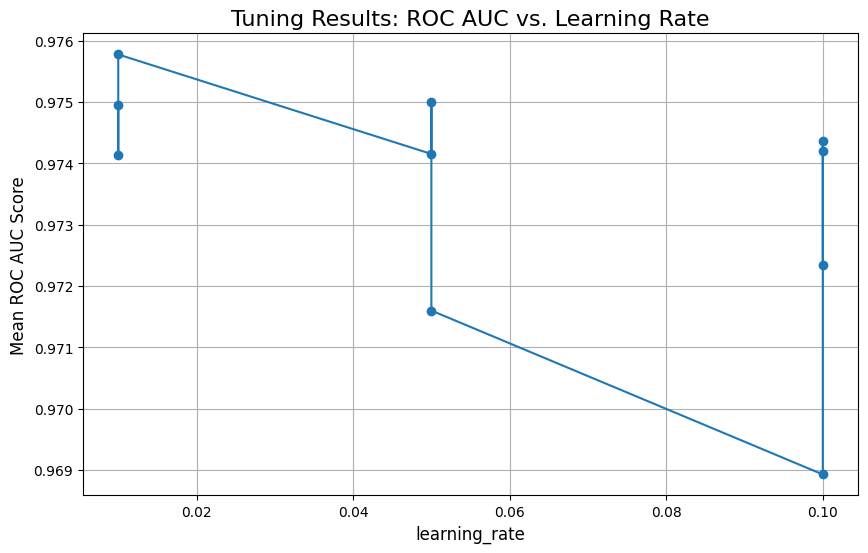

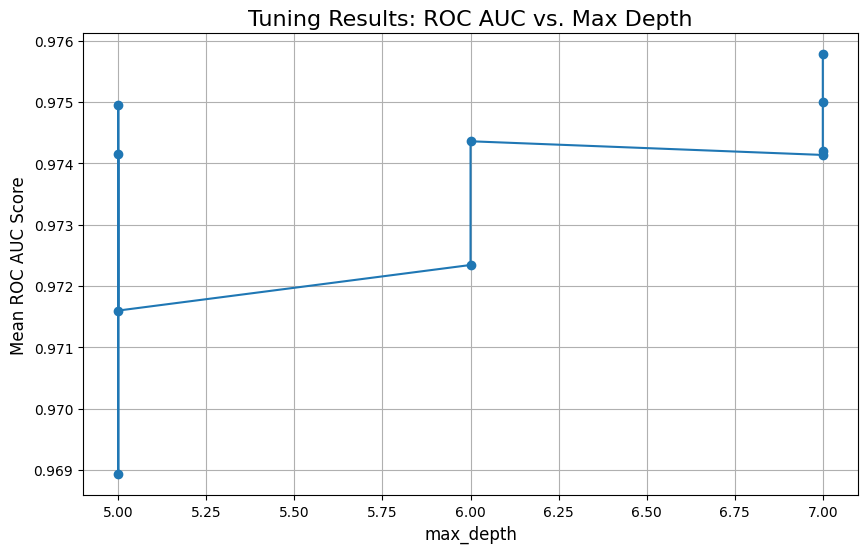

The plots above show how performance varied with different parameter settings during the search.


In [20]:
# Get the results from RandomizedSearchCV
results = random_search.cv_results_
results_df = pd.DataFrame(results)

# Plotting function to visualize tuning results
def plot_tuning_results(results_df, param_name, title):
    plt.figure(figsize=(10, 6))
    
    # Get the mean test score for each combination
    scores = results_df['mean_test_score']
    
    # Get the parameter values
    param_values = results_df[f'param_{param_name}']
    
    # Check if the parameter is a numerical type before plotting
    if pd.api.types.is_numeric_dtype(param_values):
        # Sort values for a cleaner plot
        sorted_results = results_df.sort_values(by=f'param_{param_name}')
        
        plt.plot(sorted_results[f'param_{param_name}'], sorted_results['mean_test_score'], marker='o')
        
    else:
        # If not numeric (e.g., a string), plot a swarmplot or similar
        sns.swarmplot(x=f'param_{param_name}', y='mean_test_score', data=results_df)

    plt.title(title, fontsize=16)
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel('Mean ROC AUC Score', fontsize=12)
    plt.grid(True)
    plt.show()

# Let's visualize the performance against one or two key parameters
# Choose from ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'gamma']

# Plot ROC AUC vs. learning_rate
plot_tuning_results(results_df, 'learning_rate', 'Tuning Results: ROC AUC vs. Learning Rate')

# Plot ROC AUC vs. max_depth
plot_tuning_results(results_df, 'max_depth', 'Tuning Results: ROC AUC vs. Max Depth')

print("The plots above show how performance varied with different parameter settings during the search.")

In [21]:
# Make sure to use the best_xgb_model obtained from RandomizedSearchCV
# And use X_test_reduced if you applied the low-importance feature dropping.

print("\n--- Final Evaluation on Test Set (X_test) ---")

y_pred_test = best_xgb_model.predict(X_test_model2) # Use X_test_reduced for evaluation
y_proba_test = best_xgb_model.predict_proba(X_test_model2)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_proba_test)
print(f"\nROC AUC Score: {roc_auc_test:.4f}")

# Display Feature Importances for the best model on the test set
print("\nFeature Importances (Top 20 from Best Model):")
feature_importances_final = pd.Series(best_xgb_model.feature_importances_, index=X_train_model2.columns)
print(feature_importances_final.nlargest(20))


--- Final Evaluation on Test Set (X_test) ---

Confusion Matrix:
[[1747225   33102]
 [    271    2395]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1780327
           1       0.07      0.90      0.13      2666

    accuracy                           0.98   1782993
   macro avg       0.53      0.94      0.56   1782993
weighted avg       1.00      0.98      0.99   1782993


ROC AUC Score: 0.9848

Feature Importances (Top 20 from Best Model):
merchant_state_Italy                                      0.129501
use_chip_Online Transaction                               0.128543
description_Tolls and Bridge Fees                         0.056609
credit_score_x_online_trans                               0.054536
amount_x_tolls                                            0.046177
zip                                                       0.025242
amount_x_state_haiti                                      0.023903
merch

In [22]:
print("Cleaning column names for LightGBM compatibility...")

for df_set in [X_train_model2, X_cv_model2, X_test_model2]:
    # The regex '[^A-Za-z0-9_]+' finds any character that is NOT a letter, number, or underscore
    # and replaces it with a single underscore.
    df_set.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df_set.columns]

print("Column names have been cleaned.")

# --- Verification: Display a few of the new, cleaned column names ---
print("\nSample of cleaned column names in X_train (first 10):")
print(X_train_model2.columns.tolist()[:10])

Cleaning column names for LightGBM compatibility...
Column names have been cleaned.

Sample of cleaned column names in X_train (first 10):
['amount', 'zip', 'mcc', 'client_id_card', 'num_cards_issued', 'credit_limit', 'current_age', 'retirement_age', 'gender', 'per_capita_income']


In [23]:
# Calculate scale_pos_weight (same as for XGBoost)
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

# --- Initialize and Train LightGBM Classifier ---
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    metric='logloss',
    scale_pos_weight=scale_pos_weight_value, # Crucial for imbalance
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7
)

print("Training LightGBM model...")
lgbm_model.fit(X_train_model2, y_train) # Train on the full X_train (not reduced unless you sampled for LGBM too)
print("Model training complete.\n")

# --- Evaluate on Validation Set ---
y_pred_cv_lgbm = lgbm_model.predict(X_cv_model2) # Evaluate on the full X_cv
y_proba_cv_lgbm = lgbm_model.predict_proba(X_cv_model2)[:, 1]

print("--- Evaluation of LightGBM on Validation Set (X_cv) ---")
print("\nConfusion Matrix:")
print(confusion_matrix(y_cv, y_pred_cv_lgbm))
print("\nClassification Report:")
print(classification_report(y_cv, y_pred_cv_lgbm))
roc_auc_lgbm = roc_auc_score(y_cv, y_proba_cv_lgbm)
print(f"\nROC AUC Score: {roc_auc_lgbm:.4f}")

Training LightGBM model...
[LightGBM] [Info] Number of positive: 7999, number of negative: 5340978
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4890
[LightGBM] [Info] Number of data points in the train set: 5348977, number of used features: 177
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001495 -> initscore=-6.503848
[LightGBM] [Info] Start training from score -6.503848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [24]:
# Cell 1
import os, joblib
from pprint import pprint

print("Working dir:", os.getcwd())
print("Files in dir (first 40):", os.listdir()[:40])

names = ['best_xgb_model','xgb_model_2','xgb_model','encoder','X_train_model2','X_train','median_imputations_dict']
present = {n: (n in globals()) for n in names}
print("\nPresence of important vars:")
pprint(present)

if 'model_feature_columns' not in globals():
    if 'X_train_model2' in globals():
        model_feature_columns = X_train_model2.columns.tolist()
        print("\nSet model_feature_columns from X_train_model2 (in memory).")
    elif 'X_train' in globals():
        model_feature_columns = X_train.columns.tolist()
        print("\nSet model_feature_columns from X_train (in memory).")
    else:
        print("\nmodel_feature_columns NOT found and cannot be auto-created.")


Working dir: c:\Big data analysis\finance-ba\infra\Fraud_Detection
Files in dir (first 40): ['model.ipynb', 'model_artifacts']

Presence of important vars:
{'X_train': False,
 'X_train_model2': True,
 'best_xgb_model': True,
 'encoder': True,
 'median_imputations_dict': True,
 'xgb_model': True,
 'xgb_model_2': True}

Set model_feature_columns from X_train_model2 (in memory).


In [25]:
import os
import joblib

# tạo folder nếu chưa có
artifact_dir = "model_artifacts"
os.makedirs(artifact_dir, exist_ok=True)

# save từng artifact vào folder đó
joblib.dump(best_xgb_model, os.path.join(artifact_dir, 'best_xgb_model.joblib'))
joblib.dump(encoder, os.path.join(artifact_dir, 'onehot_encoder.joblib'))
joblib.dump(model_feature_columns, os.path.join(artifact_dir, 'feature_columns.joblib'))
if 'median_imputations_dict' in globals():
    joblib.dump(median_imputations_dict, os.path.join(artifact_dir, 'median_imputations.joblib'))

print(f"All artifacts saved in folder: {artifact_dir}")


All artifacts saved in folder: model_artifacts


In [26]:
import joblib

model = joblib.load('model_artifacts/best_xgb_model.joblib')
encoder = joblib.load('model_artifacts/onehot_encoder.joblib')
feature_columns = joblib.load('model_artifacts/feature_columns.joblib')
median_imputations_dict = joblib.load('model_artifacts/median_imputations.joblib')


In [27]:
# Cell B: prepare function (chạy 1 lần)
import pandas as pd
import numpy as np

def prepare_new_data(df_new_raw):
    """
    Trả về df_ready đã xử lý, sẵn sàng cho model.predict/predict_proba.
    Phù hợp với hàm apply_preprocessing(df, is_training_set=False, median_imputations=...)
    """
    # 1) apply preprocessing: lưu ý tên tham số 'median_imputations' theo định nghĩa apply_preprocessing
    df_proc, _ = apply_preprocessing(df_new_raw, is_training_set=False, median_imputations=median_imputations_dict)
    
    # 2) merchant_state mapping nếu cần (sử dụng biến global top_15_fraud_states nếu có)
    if 'merchant_state' in df_proc.columns and 'top_15_fraud_states' in globals():
        df_proc.loc[:, 'merchant_state'] = df_proc['merchant_state'].apply(
            lambda x: x if x in top_15_fraud_states else 'OTHER_STATE'
        )

    # 3) Xác định danh sách categorical columns encoder cần
    #  - nếu encoder có attribute feature_names_in_ thì dùng nó (sklearn >= 1.0)
    #  - nếu không, fallback sang sử dụng list các cột object hiện có
    try:
        cat_cols = list(encoder.feature_names_in_)
    except Exception:
        cat_cols = [c for c in df_proc.columns if df_proc[c].dtype == 'object']

    # Đảm bảo các categorical columns tồn tại trong df_proc
    for c in cat_cols:
        if c not in df_proc.columns:
            df_proc[c] = 'UNKNOWN_CAT'

    # 4) Transform categorical với encoder đã fit (handle_unknown='ignore' nên an toàn)
    # Nếu encoder trả về ma trận numpy nhỏ (1 row), chuyển sang DataFrame với cùng index
    encoded_arr = encoder.transform(df_proc[cat_cols])
    encoded = pd.DataFrame(encoded_arr, index=df_proc.index, columns=encoder.get_feature_names_out(cat_cols))

    # 5) Kết hợp non-cat + encoded
    df_noncat = df_proc.drop(columns=cat_cols, errors='ignore')
    df_encoded = pd.concat([df_noncat, encoded], axis=1)

    # 6) Align columns theo model_feature_columns (thêm cột thiếu = 0, bỏ cột thừa)
    df_ready = pd.DataFrame(index=df_encoded.index)
    for col in model_feature_columns:
        if col in df_encoded.columns:
            df_ready[col] = df_encoded[col]
        else:
            df_ready[col] = 0  # level one-hot không xuất hiện trong mẫu mới

    df_ready = df_ready[model_feature_columns]

    # 7) đảm bảo dtype giống training (float32 cho float)
    float_cols = df_ready.select_dtypes(include=['float64']).columns
    df_ready[float_cols] = df_ready[float_cols].astype('float32')
    df_ready.fillna(0, inplace=True)

    return df_ready

print("prepare_new_data ready.")


prepare_new_data ready.


In [28]:
# --- Replacement cell: same logic but pretty / readable output ---
import pandas as pd, numpy as np, re, gc
from IPython.display import display, HTML

# sample input (thay bằng dữ liệu bạn muốn)
df_sample = pd.DataFrame([
    {'id': 1, 'client_id': 101, 'card_id': 5001, 'amount': 120, 'merchant_state': 'Italy', 'use_chip': 'Chip Transaction'},
    {'id': 2, 'client_id': 102, 'card_id': 5002, 'amount': 50,  'merchant_state': 'Spain', 'use_chip': 'Magstripe'},
    {'id': 3, 'client_id': 103, 'card_id': 5003, 'amount': 200, 'merchant_state': 'France', 'use_chip': 'Chip Transaction'}
])

#df_sample = pd.DataFrame([sample])


# Input display
print("\nInput Data:")
display(df_sample)


# 1) preprocessing
df_proc, _ = apply_preprocessing(df_sample, is_training_set=False, median_imputations=median_imputations_dict)

# merchant_state grouping nếu dùng khi train
if 'merchant_state' in df_proc.columns and 'top_15_fraud_states' in globals():
    df_proc['merchant_state'] = df_proc['merchant_state'].apply(lambda x: x if x in top_15_fraud_states else 'OTHER_STATE')

# 2) categorical handling using encoder
try:
    cat_cols = list(encoder.feature_names_in_)
except Exception:
    cat_cols = [c for c in df_proc.columns if df_proc[c].dtype == 'object']

for c in cat_cols:
    if c not in df_proc.columns:
        df_proc[c] = 'UNKNOWN_CAT'

encoded_arr = encoder.transform(df_proc[cat_cols])
encoded = pd.DataFrame(encoded_arr, index=df_proc.index, columns=encoder.get_feature_names_out(cat_cols))
df_noncat = df_proc.drop(columns=cat_cols, errors='ignore')
df_encoded = pd.concat([df_noncat, encoded], axis=1)

# 3) expected feature names
expected_cols = None
if 'best_xgb_model' in globals():
    try:
        expected_cols = best_xgb_model.get_booster().feature_names
    except Exception:
        expected_cols = None

if expected_cols is None:
    if 'model_feature_columns' in globals():
        expected_cols = list(model_feature_columns)
    else:
        raise RuntimeError("Không tìm được expected feature list. Hãy đảm bảo best_xgb_model hoặc model_feature_columns tồn tại.")

# 4) normalize helper
def normalize_name(s):
    s = str(s) if s is not None else ''
    s = re.sub(r'[^A-Za-z0-9]+', '_', s).strip('_').lower()
    return s

norm_expected = { normalize_name(c): c for c in expected_cols }
df_cols = df_encoded.columns.tolist()
norm_dfcols = { normalize_name(c): c for c in df_cols }

# 5) Build mapping dict (one-shot) to avoid fragmentation
mapped = {}
matched = []
missing_expected = []

n_rows = len(df_encoded)
for norm_key, exp_col in norm_expected.items():
    if norm_key in norm_dfcols:
        src_col = norm_dfcols[norm_key]
        mapped[exp_col] = df_encoded[src_col].astype('float32').to_numpy()
        matched.append((exp_col, src_col))
    else:
        mapped[exp_col] = np.zeros(n_rows, dtype='float32')
        missing_expected.append(exp_col)

# 6) Create df_ready in one go
df_ready = pd.DataFrame(mapped, index=df_encoded.index, dtype=np.float32)
df_ready = df_ready[expected_cols].fillna(0).astype(np.float32)

gc.collect()

# --------------------------- Predictions---------------------------
probs = best_xgb_model.predict_proba(df_ready)[:, 1]
preds = (probs > 0.5).astype(int)

out = df_sample.copy()
out['probs'] = probs
out['is_fraud'] = preds

# format fraud_probability to 4 decimals for readability
out_display = out.copy()
out_display['probs'] = out_display['probs'].map(lambda x: f"{x:.4f}")

print("\nPrediction Result:")
display(out_display)

# Also print a short human-readable line
print("\nSummary:")
for i, row in out.iterrows():
    print(f"• Input row {i + 1}: probs = {row['probs']:.4f}  → is_fraud = {int(row['is_fraud'])}")

# -----------------------------------------------------------------------------



Input Data:


,id,client_id,card_id,amount,merchant_state,use_chip
0,1,101,5001,120,Italy,Chip Transaction
1,2,102,5002,50,Spain,Magstripe
2,3,103,5003,200,France,Chip Transaction



Prediction Result:


,id,client_id,card_id,amount,merchant_state,use_chip,probs,is_fraud
0,1,101,5001,120,Italy,Chip Transaction,0.9396,1
1,2,102,5002,50,Spain,Magstripe,0.0533,0
2,3,103,5003,200,France,Chip Transaction,0.0479,0



Summary:
• Input row 1: probs = 0.9396  → is_fraud = 1
• Input row 2: probs = 0.0533  → is_fraud = 0
• Input row 3: probs = 0.0479  → is_fraud = 0
